## Density Estimation

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
from scipy import stats, integrate
from sklearn.neighbors import KernelDensity

from nose.tools import assert_equal, assert_is_instance, assert_is_not
from numpy.testing import assert_array_equal, assert_array_almost_equal, assert_almost_equal
from pandas.util.testing import assert_frame_equal

In [2]:
df = pd.read_csv('2001.csv', encoding='latin-1', usecols=(13, 16))

In [3]:
local = df[df['Origin'] == 'CMI']
local = local.drop(['Origin'], axis=1) 
local.dropna(inplace=True)

### Rug plots

In [294]:
def plot_rugplot(df, column='AirTime', jitter=0.0, seed=0):
    '''
    Plots a rug plot.
    
    Parameters
    ----------
    df: A pandas.DataFrame
    column: The column to use in "df"
    jitter: An int or float. Default: 0.
            If jitter > 0, uses numpy.random.normal() to draw
            random samples from a normal distribution with zero mean
            and standard deviatation equal to "jitter".
    seed: An int. Used by numpy.random.seed().
    
    Returns
    -------
    A matplotlib.axes.Axes
    '''
    
    data = []
    if jitter>0:
        np.random.seed(seed=seed)
        new=data.append(df[column] + np.random.normal(0, jitter, len(df[column])))
    elif jitter<=0:
        new=data.append(df[column])
    fig, ax = plt.subplots(figsize=(8, 2))
    clr=sns.xkcd_rgb["pale red"]
    for dat in data:
        sns.rugplot(ax=ax, a=dat, height=0.5, c = clr)
        ax.set_yticks([])
        ax.set_xlim(20, 90)
        ax.set_xlabel('AirTime', fontsize=14)
        sns.despine(left=True, offset=2, trim=True)
    return ax

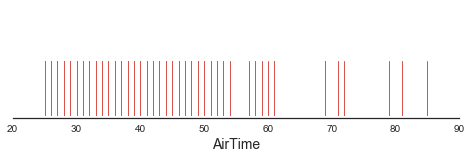

In [295]:
rug_no_jitter = plot_rugplot(df=local, jitter=0, seed=0)

In [296]:
assert_is_instance(rug_no_jitter, mpl.axes.Axes)
assert_equal(len(rug_no_jitter.lines), len(local))

for i in range(len(local)):
    xdata, ydata = rug_no_jitter.lines[i].get_xydata().T
    assert_array_equal(xdata, local.iloc[i, 0])
    assert_equal(ydata[1] - ydata[0] > 0, True)
    
assert_is_not(rug_no_jitter.xaxis.get_label_text(), '',
    msg="Change the x-axis label to something more descriptive.")

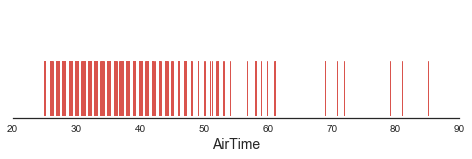

In [297]:
rug_jittered = plot_rugplot(df=local, jitter=0.1, seed=0)

In [298]:
assert_equal(len(rug_jittered.lines), len(local))

np.random.seed(0)
for i in range(len(local)):
    xdata, ydata = rug_jittered.lines[i].get_xydata().T
    assert_equal(xdata[0], xdata[1])
    assert_almost_equal(xdata[0], local.iloc[i, 0] + np.random.normal(0, 0.1)) # jitter is 0.1
    assert_equal(ydata[1] - ydata[0] > 0, True)
    
assert_is_not(rug_jittered.xaxis.get_label_text(), '',
    msg="Change the x-axis label to something more descriptive.")

### Histograms

In [321]:
def plot_histogram(df, bins, column='AirTime', normed=False):
    '''
    Plots a histogram.
    
    Parameters
    ----------
    df: A pandas.DataFrame
    column: The column to use in "df"
    normed: If true, the integral of the histogram will sum to 1
            (i.e. normalized) to form a probability density.
    
    Returns
    -------
    A matplotlib.axes.Axes
    '''
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.hist(df[column], bins=bins, color=sns.xkcd_rgb["denim blue"],alpha=0.5,edgecolor='black', normed=normed)
    ax.set_title('Histogram with {} bins'.format(bins),fontsize=14)
    ax.set_xlabel('AirTime', fontsize=14)
    ax.set_ylabel('Counts', fontsize=14)
    ax.set_xlim(20,90)
    sns.despine()
    return ax

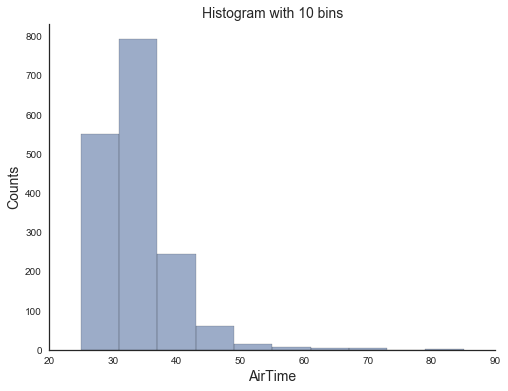

In [322]:
hist_10_bins = plot_histogram(df=local, bins=10)

In [323]:
assert_is_instance(hist_10_bins, mpl.axes.Axes)
patches = hist_10_bins.patches
assert_equal(len(patches), 10)

bins_a = [25.,  31.,  37.,  43.,  49.,  55.,  61.,  67.,  73.,  79.,  85.]
counts_a = [550, 792, 245,  61,  15,   7,   4,   4,   0,   3]
                    
for i in range(len(patches)):
    assert_equal(patches[i].get_x(), bins_a[i])
    assert_equal(patches[i].get_height(), counts_a[i])

# check label texts
assert_is_not(len(hist_10_bins.title.get_text()), 0,
    msg="Your plot doesn't have a title.")
assert_is_not(hist_10_bins.xaxis.get_label_text(), '',
    msg="Change the x-axis label to something more descriptive.")
assert_is_not(hist_10_bins.yaxis.get_label_text(), '',
    msg="Change the x-axis label to something more descriptive.")

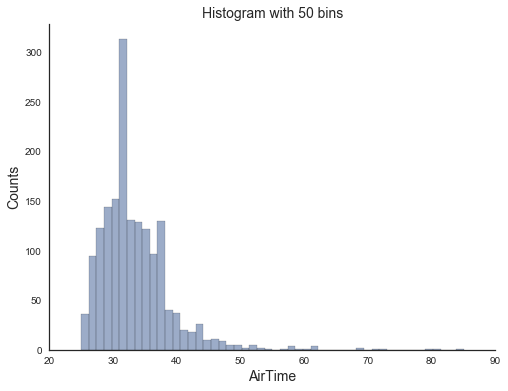

In [324]:
hist_50_bins = plot_histogram(df=local, bins=50)

In [325]:
assert_is_instance(hist_50_bins, mpl.axes.Axes)
patches = hist_50_bins.patches
assert_equal(len(patches), 50)

### distplot

In [337]:
def plot_distplot(df, bins, column='AirTime'):
    '''
    Plots a "distplot".
    
    Parameters
    ----------
    df: A pandas.DataFrame
    bins: The number of bins
    column: The column to use in "df"
    
    Returns
    -------
    A matplotlib.axes.Axes
    '''
    
    ax = sns.distplot(df[column], kde=True, rug=True, bins=bins,hist_kws={"edgecolor": "black"})
    ax.set_xlim(20, 90)
    ax.set_xlabel('AirTime', fontsize=14)
    ax.set_ylabel('Counts', fontsize=14)
    ax.set_title('Distplot with {} bins'.format(bins),fontsize=14)
    sns.despine()
    return ax

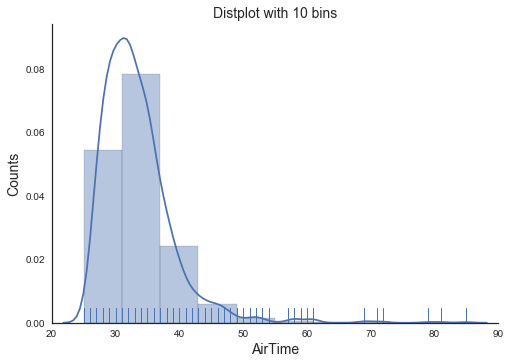

In [338]:
dist_10_bins = plot_distplot(df=local, bins=10)

In [339]:
assert_is_instance(dist_10_bins, mpl.axes.Axes)

# test histogram
patches = dist_10_bins.patches
assert_equal(len(patches), 10)

bins_a = [25.,  31.,  37.,  43.,  49.,  55.,  61.,  67.,  73.,  79.,  85.]
freq_a = [0.05453103,  0.07852469,  0.0242911,   0.00604799,  0.00148721,
          0.00069403,  0.00039659,  0.00039659,  0.,          0.00029744]

for i in range(len(patches)):
    assert_equal(patches[i].get_x(), bins_a[i])
    assert_almost_equal(patches[i].get_height(), freq_a[i])

# test kde + rug plots
lines = dist_10_bins.lines
assert_equal(len(dist_10_bins.lines), len(local) + 1) # 1 kde + rug plots

# test kde
kdex, kdey = dist_10_bins.lines[0].get_xydata().T
assert_almost_equal(np.trapz(kdey, kdex), 1.0, 4)

# test rug plots
for i in range(len(local)):
    rugx, rugy = dist_10_bins.lines[i + 1].get_xydata().T
    assert_array_equal(rugx, local.iloc[i, 0])
    assert_equal(rugy[1] - rugy[0] > 0, True)
    
# check label texts
assert_is_not(len(dist_10_bins.title.get_text()), 0,
    msg="Your plot doesn't have a title.")
assert_is_not(dist_10_bins.yaxis.get_label_text(), '',
    msg="Change the y-axis label to something more descriptive.")

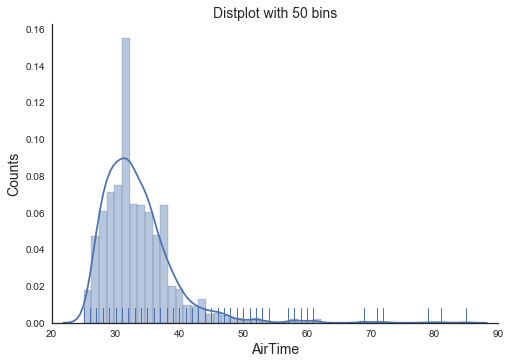

In [340]:
dist_50_bins = plot_distplot(df=local, bins=50)

In [341]:
assert_is_instance(dist_50_bins, mpl.axes.Axes)
patches = dist_50_bins.patches
assert_equal(len(patches), 50)

### Silverman's rule of thumb

In [13]:
def get_silverman_bandwidth(df, column='AirTime'):
    '''
    Calculates bandwidth for KDE using Silverman's rule of thumb.
    
    Parameters
    ----------
    df: A pandas.DataFrame
    column: The column to use in "df"
    
    Returns
    -------
    A float
    '''
    
    n=len(df[column])
    std=np.std(np.array(df[column]))
    bw=1.06 * std * n ** (-1 / 5)
    return bw

In [14]:
rs = np.random.RandomState(0)
bw_t = pd.DataFrame({'AirTime': rs.randn(100)})
assert_almost_equal(get_silverman_bandwidth(bw_t), 0.425, 3)

rs = np.random.RandomState(0)
bw_t = pd.DataFrame({'AirTime': rs.randn(200)})
assert_almost_equal(get_silverman_bandwidth(bw_t), 0.375, 3)

### Gaussian Kernels

In [16]:
def get_kernels(df, support, column='AirTime'):
    '''
    Generates Gaussian kernels.
    
    Parameters
    ----------
    df: A pandas.DataFrame.
    support: Input data points for the probability density function.
    column: The column that will be used in "df"
    
    Returns
    -------
    A 2-d numpy array
    '''
    
    bw=get_silverman_bandwidth(df, column='AirTime')
    kernels = []
    for d in df[column]:
        kernel = stats.norm(d, bw).pdf(support)
        kernels.append(kernel)
    return kernels

In [19]:
support_t = np.linspace(0, 1, 5)
rs = np.random.RandomState(0)
df_t = pd.DataFrame({'AirTime': rs.rand(2)})
kernels_t = get_kernels(df=df_t, support=support_t)
kernels_a = np.array(
    [[4.13769545e-11, 2.66353480e-03, 4.24566728e+00, 1.67579644e-01, 1.63788836e-07],
     [7.36686859e-19, 5.51357055e-08, 1.02181124e-01, 4.68917176e+00, 5.32855352e-03]]
    )
assert_array_almost_equal(kernels_t, kernels_a)

### Kernel density estimate

In [20]:
def normalize_kernels(support, kernels):
    '''
    Sums up the individual kernels and normalizes by total area.

    Parameters
    ----------
    support: A 1-d numpy array.
             Input data points for the probability density function.
    kernels: A 2-d numpy array.
             Kernels generated from "get_kernels()"
             
    Returns
    -------
    A 1-d numpy array
    '''
    
    density = np.sum(kernels, axis=0)
    density /= integrate.trapz(density, support)
    return density

In [21]:
density_t = normalize_kernels(support=support_t, kernels=kernels_t)
density_a = np.array(
    [1.797059e-11, 1.156834e-03, 1.888331e+00, 2.109355e+00, 2.314336e-03]
    )
assert_array_almost_equal(density_t, density_a)

### Plot KDE (scipy version)

In [60]:
def plot_scipy_kde(df, support, column='AirTime', bins=50):
    '''
    Plots a KDE (using scipy functions) over a histogram.
    
    Parameters
    ----------
    df: A pandas.DataFrame
    support: A 1-d numpy array.
             Input data points for the probability density function.
    
    Returns
    -------
    A matplotlib.axes.Axes instance.
    '''
    
    kernels=get_kernels(df, support, column)
    density=normalize_kernels(support, kernels)
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(support, density, color=sns.xkcd_rgb["denim blue"], linewidth=2)
    ax.hist(df[column], bins, alpha=0.6, edgecolor='black', normed=True)
    ax.set_xlim(20, 90)
    ax.set_xlabel('AirTime', fontsize=14)
    ax.set_ylabel('Counts', fontsize=14)
    ax.set_title('Kernel Density Plot(scipy)',fontsize=14)
    sns.despine()
    return ax

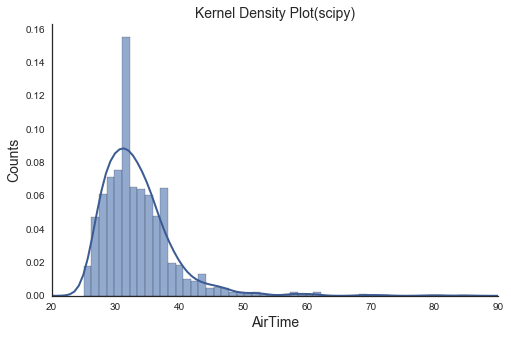

In [61]:
support = np.linspace(20, 90, 100)
kde_scipy = plot_scipy_kde(df=local, support=support)

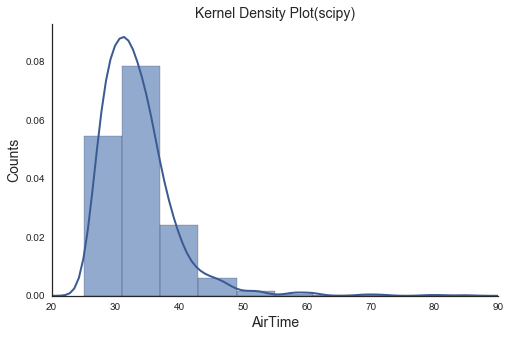

In [62]:
kde_scipy_t = plot_scipy_kde(df=local, support=support, bins=10)
assert_is_instance(kde_scipy_t, mpl.axes.Axes)

# test histogram
patches = kde_scipy_t.patches
assert_equal(len(patches), 10)

bins_a = [25.,  31.,  37.,  43.,  49.,  55.,  61.,  67.,  73.,  79.,  85.]
freq_a = [0.05453103,  0.07852469,  0.0242911,   0.00604799,  0.00148721,
          0.00069403,  0.00039659,  0.00039659,  0.,          0.00029744]

for i in range(len(patches)):
    assert_equal(patches[i].get_x(), bins_a[i])
    assert_almost_equal(patches[i].get_height(), freq_a[i])

# test kde
lines = kde_scipy_t.lines
assert_equal(len(kde_scipy_t.lines), 1)
kdex, kdey = kde_scipy_t.lines[0].get_xydata().T
assert_almost_equal(np.trapz(kdey, kdex), 1.0, 4)

# check label texts
assert_is_not(len(kde_scipy_t.title.get_text()), 0,
    msg="Your plot doesn't have a title.")
assert_is_not(kde_scipy_t.yaxis.get_label_text(), '',
    msg="Change the y-axis label to something more descriptive.")

### Plot KDE (sklearn version)

In [65]:
def plot_sklearn_kde(df, support, column='AirTime', bins=50):
    '''
    Plots a KDE and a histogram using sklearn.KernelDensity.
    Uses Gaussian kernels.
    The optimal bandwidth is calculated according to Silverman's rule of thumb.
    
    Parameters
    ----------
    df: A pandas.DataFrame
    support: A 1-d numpy array.
             Input data points for the probability density function.
    
    Returns
    -------
    ax: A matplotlib.axes.Axes instance.
    kde: A sklearn.neighbors.kde.KernelDensity instance.
    '''
    
    bw=get_silverman_bandwidth(df, column='AirTime')
    kde = KernelDensity(kernel='gaussian', bandwidth=bw)
    x=df[column]
    kde.fit(x[:, np.newaxis])
    y = kde.score_samples(support[:, np.newaxis])
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.hist(x, bins=bins, alpha=0.5, color=sns.xkcd_rgb["denim blue"], edgecolor='black',normed=True)
    ax.plot(support, np.exp(y))
    ax.set_xlim(20, 90)
    ax.set_xlabel('AirTime', fontsize=14)
    ax.set_ylabel('Counts', fontsize=14)
    ax.set_title('Kernel Density Plot(sklearn)',fontsize=14)
    sns.despine()
    return ax, kde

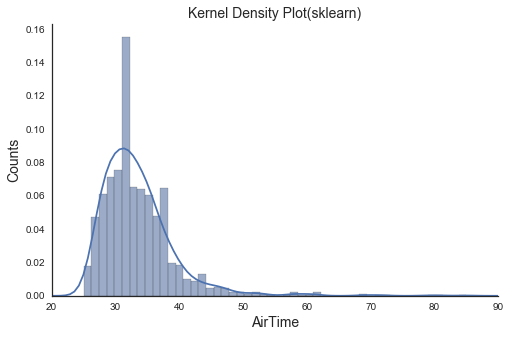

In [66]:
ax_kde_sklearn, kde_sklearn = plot_sklearn_kde(df=local, support=support)

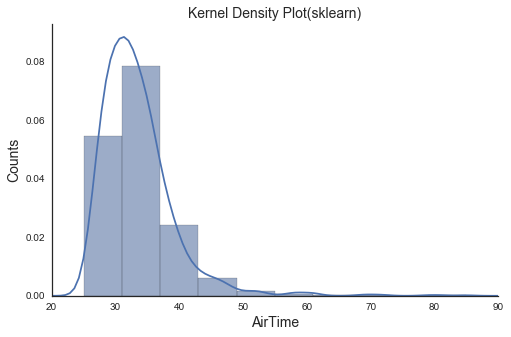

In [67]:
ax_kde_sklearn_t, kde_sklearn_t = plot_sklearn_kde(df=local, support=support, bins=10)
assert_is_instance(ax_kde_sklearn_t, mpl.axes.Axes)
assert_is_instance(kde_sklearn_t, KernelDensity)

# test histogram
patches = ax_kde_sklearn_t.patches
assert_equal(len(patches), 10)

bins_a = [25.,  31.,  37.,  43.,  49.,  55.,  61.,  67.,  73.,  79.,  85.]
freq_a = [0.05453103,  0.07852469,  0.0242911,   0.00604799,  0.00148721,
          0.00069403,  0.00039659,  0.00039659,  0.,          0.00029744]

for i in range(len(patches)):
    assert_equal(patches[i].get_x(), bins_a[i])
    assert_almost_equal(patches[i].get_height(), freq_a[i])

# test kde
lines = ax_kde_sklearn_t.lines
assert_equal(len(ax_kde_sklearn_t.lines), 1)
kdex, kdey = ax_kde_sklearn_t.lines[0].get_xydata().T
assert_almost_equal(np.trapz(kdey, kdex), 1.0, 4)

# check label texts
assert_is_not(len(ax_kde_sklearn_t.title.get_text()), 0,
    msg="Your plot doesn't have a title.")
assert_is_not(ax_kde_sklearn_t.yaxis.get_label_text(), '',
    msg="Change the y-axis label to something more descriptive.")